<a href="https://colab.research.google.com/github/eeolga/article/blob/main/3D_merged_weighted_data_corelation_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
import pandas as pd

In [3]:
CAD_path="/content/combined_data_12102024.xlsx"

CAD_logs file data

In [4]:
data = pd.read_excel("/content/combined_data_12102024.xlsx")

In [5]:
display(pd.DataFrame(data))

,timestamp,userid,toolid,activityid,competency_weight,tool_weight,activity_weight
0,"1/02/24, 10:46:00",18630,233150,10503,0.0152,0.0370,0.0543
1,"1/03/24, 09:50:22",21041,233162,20807,0.0455,0.1111,0.1628
2,"1/03/24, 09:50:32",21041,233162,20807,0.0455,0.1111,0.1628
3,"1/03/24, 09:50:37",21041,256461,30807,0.0606,0.1481,0.2171
4,"1/03/24, 09:57:15",21041,256461,30807,0.0606,0.1481,0.2171
...,...,...,...,...,...,...,...
7470,"9/05/24, 16:09:17",29275,233172,10403,0.0303,0.0370,0.0715
7471,"9/05/24, 16:09:24",29275,256461,20807,0.0455,0.1111,0.1628
7472,"9/06/24, 00:22:05",26342,233144,10303,0.0152,0.0370,0.0543
7473,"9/06/24, 21:31:13",26502,258703,40807,0.0758,0.1852,0.2714


Feature Engineering

In [6]:
df = pd.read_excel("/content/combined_data_12102024.xlsx")
test_df = pd.read_excel("/content/combined_data_12102024.xlsx")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7475 entries, 0 to 7474
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          7475 non-null   object 
 1   userid             7475 non-null   int64  
 2   toolid             7475 non-null   int64  
 3   activityid         7475 non-null   int64  
 4   competency_weight  7475 non-null   float64
 5   tool_weight        7475 non-null   float64
 6   activity_weight    7475 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 408.9+ KB


In [7]:
def feature_engineering(df): #feature engineering function

    return df

In [8]:
df = feature_engineering(df)

In [9]:
df = df.drop(['timestamp'], axis=1) # Remove columns I no longer need

In [10]:
def scale_min_max(df, col_name, xmin, xmax):  # Normalization
    df[col_name] = (df[col_name] - xmin) / (xmax - xmin)
    return df

train_activity_min = df['activity_weight'].min()
train_activity_max = df['activity_weight'].max()
df = scale_min_max(df, 'activity_weight', train_activity_min, train_activity_max)

df['activity_weight'].describe()

,activity_weight
count,7475.000000
mean,0.573692
std,0.313842
min,0.000000
25%,0.499770
50%,0.499770
75%,0.754491
max,1.000000


Data correlation

In [25]:
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:16], all_data.loc[16:].drop(['timestamp'], axis=1)

df_train = pd.read_excel("/content/combined_data_12102024.xlsx")
df_test = pd.read_excel("/content/combined_data_12102024.xlsx")


df_train.name = 'Training Set'
df_test.name = 'Test Set'


dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['activity_weight'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 7475
Number of Test Examples = 7475

Training X Shape = (7475, 7)
Training y Shape = 7475

Test X Shape = (7475, 7)
Test y Shape = 7475

Index(['timestamp', 'userid', 'toolid', 'activityid', 'competency_weight',
       'tool_weight', 'activity_weight'],
      dtype='object')
Index(['timestamp', 'userid', 'toolid', 'activityid', 'competency_weight',
       'tool_weight', 'activity_weight'],
      dtype='object')


In [13]:
# Ensure 'timestamp' column is dropped from both training and test datasets
df_train_cleaned = df_train.drop(['timestamp'], axis=1)
df_test_cleaned = df_test.drop([ 'timestamp'], axis=1)

In [14]:
# Verify all columns in df_train_cleaned and df_test_cleaned are numeric
numeric_columns_train = df_train_cleaned.select_dtypes(include=[int, float]).columns
numeric_columns_test = df_test_cleaned.select_dtypes(include=[int, float]).columns

In [15]:
# Compute correlations only on numeric columns
df_train_corr = df_train_cleaned[numeric_columns_train].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)


In [16]:
df_test_corr = df_test_cleaned[numeric_columns_test].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [17]:
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1 # Training set correlations
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,activity_weight,tool_weight,0.997938
8,competency_weight,activity_weight,0.986920
10,tool_weight,competency_weight,0.974543
12,competency_weight,activityid,0.941415
14,activityid,activity_weight,0.939679
16,activityid,tool_weight,0.932179
18,tool_weight,toolid,0.331692
20,toolid,activity_weight,0.319093
22,activityid,toolid,0.290977
24,competency_weight,toolid,0.281318


In [18]:
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,activity_weight,tool_weight,0.997938
8,competency_weight,activity_weight,0.986920
10,tool_weight,competency_weight,0.974543
12,competency_weight,activityid,0.941415
14,activityid,activity_weight,0.939679
16,activityid,tool_weight,0.932179
18,tool_weight,toolid,0.331692
20,toolid,activity_weight,0.319093
22,activityid,toolid,0.290977
24,competency_weight,toolid,0.281318


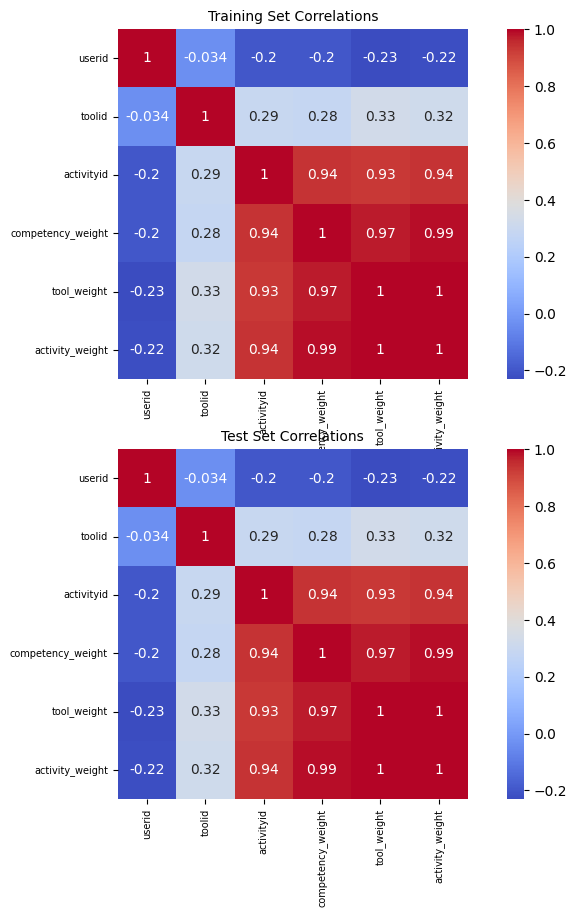

In [19]:
import matplotlib.pyplot as plt # Import the matplotlib library and give it the alias 'plt'
import seaborn as sns

fig, axs = plt.subplots(nrows=2, figsize=(10, 10))

sns.heatmap(df_train.drop(['timestamp'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})
sns.heatmap(df_test.drop(['timestamp'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=7)
    axs[i].tick_params(axis='y', labelsize=7)

axs[0].set_title('Training Set Correlations', size=10)
axs[1].set_title('Test Set Correlations', size=10)

plt.show()

Data model training

Index(['timestamp', 'userid', 'toolid', 'activityid', 'competency_weight',
       'tool_weight', 'activity_weight'],
      dtype='object')
Non-numeric columns: Index(['timestamp'], dtype='object')
Epoch [10/50], Loss: 0.4649, Val Loss: 0.4467
Epoch [20/50], Loss: 0.2699, Val Loss: 0.2485
Epoch [30/50], Loss: 0.1014, Val Loss: 0.0893
Epoch [40/50], Loss: 0.0301, Val Loss: 0.0265
Epoch [50/50], Loss: 0.0105, Val Loss: 0.0095


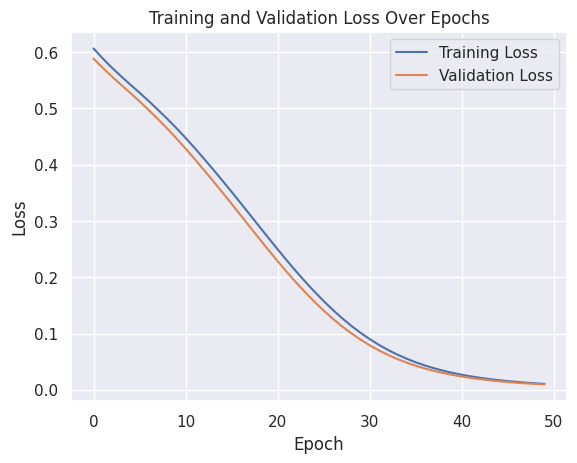

Raw outputs (first 10): tensor([0.0005, 0.0286, 0.0008, 0.0280, 0.0060, 0.0005, 0.0016, 0.0175, 0.0284,
        0.0004])
Unique values in predictions with threshold 0.5: tensor([0.])
Only one class (0.0) predicted with threshold 0.5.


In [22]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Load Data from Excel
file_path = '/content/combined_data_12102024.xlsx'
data = pd.read_excel(file_path)

# Print the column names to verify 'competency' exists
print(data.columns)

# Assuming your Excel file has columns 'features' and 'target'
# Adjust 'competency' to the actual column name if necessary
X = data.drop('competency_weight', axis=1)
y = data['competency_weight'].values

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Handle non-numeric columns (example: drop them)
X = X.drop(non_numeric_cols, axis=1).values

# Ensure target values are 0 or 1
y = (y == 1).astype(float)

#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
num_epochs = 50
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.5
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))

Index(['timestamp', 'userid', 'toolid', 'activityid', 'competency_weight',
       'tool_weight', 'activity_weight'],
      dtype='object')
Non-numeric columns: Index(['timestamp'], dtype='object')
Epoch [20/100], Loss: 0.2258, Val Loss: 0.1964
Epoch [40/100], Loss: 0.0159, Val Loss: 0.0133
Epoch [60/100], Loss: 0.0031, Val Loss: 0.0027
Epoch [80/100], Loss: 0.0016, Val Loss: 0.0014
Epoch [100/100], Loss: 0.0011, Val Loss: 0.0010


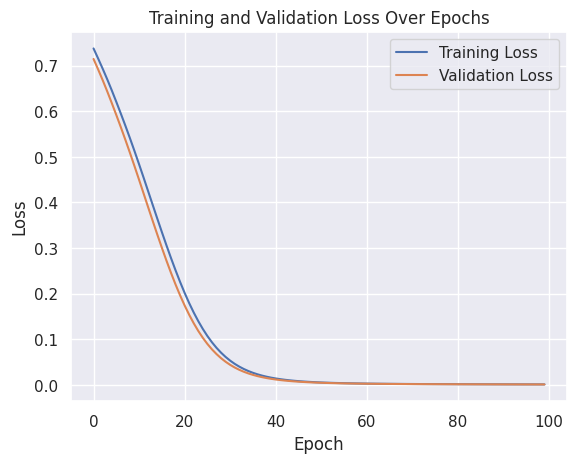

Raw outputs (first 10): tensor([6.8497e-06, 1.3077e-03, 2.8518e-06, 5.1345e-03, 1.7605e-03, 8.4809e-06,
        3.7706e-06, 6.9437e-04, 1.2774e-03, 2.6072e-06])
Unique values in predictions with threshold 0.3: tensor([0.])
Only one class (0.0) predicted with threshold 0.3.


In [24]:
# Load Data from Excel
file_path = '/content/combined_data_12102024.xlsx'
data = pd.read_excel(file_path)

# Print the column names to verify 'competency' exists
print(data.columns)

# Assuming your Excel file has columns 'features' and 'target'
# Adjust 'competency' to the actual column name if necessary
X = data.drop('competency_weight', axis=1)
y = data['competency_weight'].values

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Handle non-numeric columns (example: drop them)
X = X.drop(non_numeric_cols, axis=1).values

# Ensure target values are 0 or 1
y = (y == 1).astype(float)

#  Preprocess Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Model
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

input_dim = X_train.shape[1]
model = ImprovedNN(input_dim)

# SDefine Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
num_epochs = 100
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        validation_losses.append(val_loss.item())

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    raw_outputs = model(X_test)
    print(f'Raw outputs (first 10): {raw_outputs[:10].flatten()}')

    # Adjust threshold if necessary
    threshold = 0.3
    y_predicted = (raw_outputs > threshold).float()
    unique_values = y_predicted.unique()
    print(f'Unique values in predictions with threshold {threshold}: {unique_values}')

    y_test_flat = y_test.flatten()
    if len(unique_values) == 1:
        print(f'Only one class ({unique_values.item()}) predicted with threshold {threshold}.')
    else:
        print(classification_report(y_test_flat, y_predicted, target_names=['class 0', 'class 1']))